# Twitter Sentiment Analysis using Machine Learning

## Introduction

- Sentiment Analysis: Interpretation and Classification of emotions, (which can be either positive or negative) using textual analysis. This is a very useful technique and allows organizations and bodies to identify mass sentiments towards certain topics of interest.

## Goal

- The goal of the project is to develop a Sentiment Analysis Machine Learning model to categorize tweets as "Positive" (happy) or "Negative" (sad). 

In [ ]:
!pip install -q wordcloud
# Importing essential libraries

import numpy as np
import pandas as pd
import string
import re # regex for preprocessing the tweets
import pickle

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rc

# NLTK i.e Natural Language ToolKit is used for the purpose of text processing and cleaning
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# sklearn libraries
# TfidVectorize encodes data into numbers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# machine learning libraries
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

# utils
from collections import Counter, defaultdict
from bs4 import BeautifulSoup  
from pylab import rcParams
import math
from tqdm import tqdm
from scipy.sparse import csr_matrix
import operator
from sklearn.preprocessing import normalize

# Dataset

We are using **sentiment140 dataset** from kaggle which contains 1.6 million tweets scraped from twitter using the twitter API. Each tweet is given a label, 0 being negative and 4 being positive and can be used to detect and predict sentiments. 

The dataset has following fields:

1. **Sentiment**: Sentiment of the tweet. 0 = Negative, 4 = Positive
2. **Tweet ID**:  Tweet ID
3. **Date**:      Date and time of tweet
4. **Flag**:      NO_QUERY
5. **User**:      Owner of the tweet
6. **Tweet**:     Body of the tweet

The only fields of concern for us are the **Sentiment** and the **Tweet** field and we can do away with rest of the fields.

In [ ]:
# mounting google drive to get the dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# unzipping the dataset
from zipfile import ZipFile

with ZipFile('/content/gdrive/MyDrive/ML Dataset/training.1600000.processed.noemoticon.csv.zip') as z:
  z.extractall(path='/content')

In [ ]:
COLUMNS = ["Sentiment", "ID", "Date", "Flag", "User", "Tweet"]
# reading the dataset into pandas dataframe
# ISO-8859-1 is used in order to encoding non-english characters. (Latin characters)
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", names=COLUMNS)
print(df.head(5))

   Sentiment  ...                                              Tweet
0          0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  ...  is upset that he can't update his Facebook by ...
2          0  ...  @Kenichan I dived many times for the ball. Man...
3          0  ...    my whole body feels itchy and like its on fire 
4          0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]


In [ ]:
# Removing unnecessary columns
df = df[['Sentiment', 'Tweet']]
# For the ease of understanding we'll replace label encoding from 0-4 to 0-1
df['Sentiment'] = df['Sentiment'].replace(4,1)

## Visualization

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

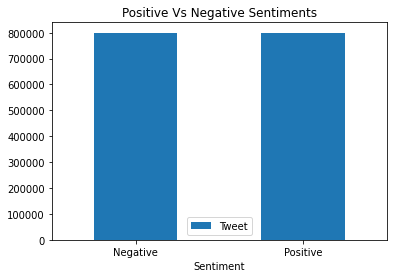

In [ ]:
# plotting the data (Positive vs Negative sentiments)
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Positive Vs Negative Sentiments')
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

In [ ]:
tweet, sentiment = list(df['Tweet']), list(df['Sentiment'])
print(tweet[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [ ]:
# creating a stop word set
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text Preprocessing

Text Preprocessing is an important task prior to applying machine learning algorithms. It transforms text into more digestable form so that ML algorithms can perform significantly better

Following steps were taken for preprocessing (NLTK was instrumental in the preprocessing step, we are leveraging NLTK libraries to perform these processing):
1. Lower casing each text
2. Replacing urls i.e words starting with **http**, **https** or **www** are replaced by "" as urls are not of much use.
3. Remove **@** and **#** references
4. Removing punctuations
5. Removing Stopwords: Stopwords are the english words which do not add much meaning to a sentence. Eg: "He", "She", "hi"
6. Lemmatizing: Process of converting a word into it's base form. (Eg: Great->Good)


In [ ]:
# dependencies for lemmatization
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_tweet_text(tweet_data):
  processed_tweet = []
  for tweet in tweet_data:
    # lower casing
    tweet = tweet.lower()

    # removing an URL from the tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # removing punctuations
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))  
    # removing @ and # references
    tweet = re.sub(r'\@\w+|\#', "", tweet)
    # removing non alphabetic characters
    tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)

    # tokenizing i.e seperating the words by a space
    tweet_tokens = word_tokenize(tweet)

    # removing stop words
    filtered_words = [word for word in tweet_tokens if word not in stop_words]

    # text normalization using nltk lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    tweet_words = ''
    for word in filtered_words:
      word = lemmatizer.lemmatize(word)
      tweet_words += (word+' ')
    
    processed_tweet.append(tweet_words)
  return processed_tweet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
proceseed_tweets = preprocess_tweet_text(tweet)

In [ ]:
print(proceseed_tweets[0])

switchfoot thats bummer shoulda got david carr third day 


# Analysing the data

Next, we analyse the processed data to get a deeper insight of the data. In order to do so, we'll plot **Word Clouds** for all the positive and negative tweets. This will help us know which words occur the most. 

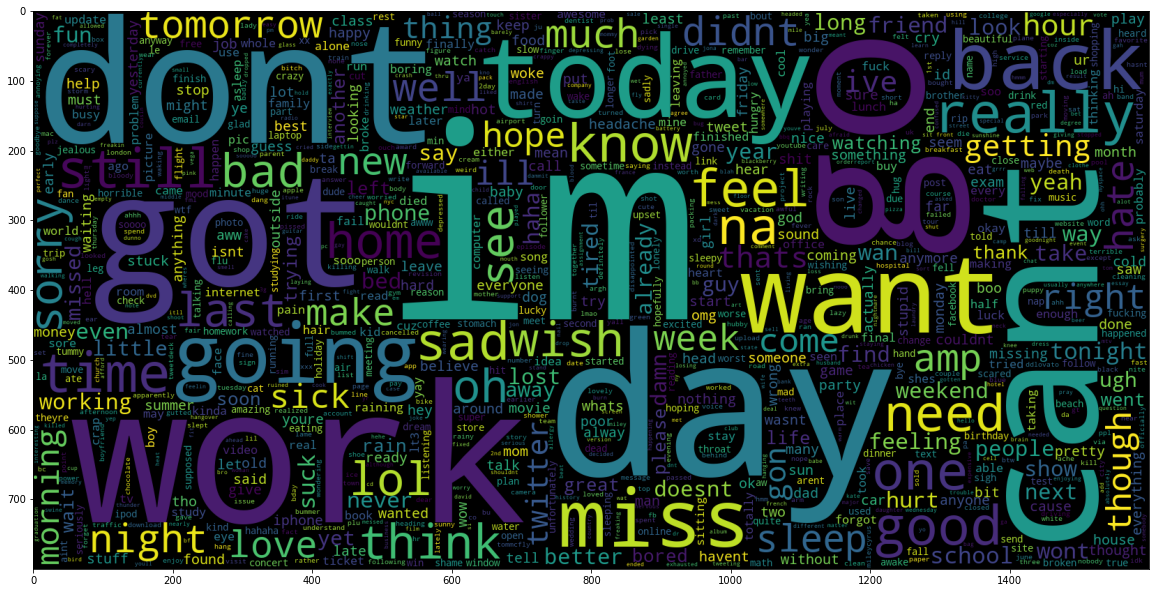

In [ ]:
# Plotting negative tweets

negative_plot = proceseed_tweets[:800000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(negative_plot))
plt.imshow(wc)

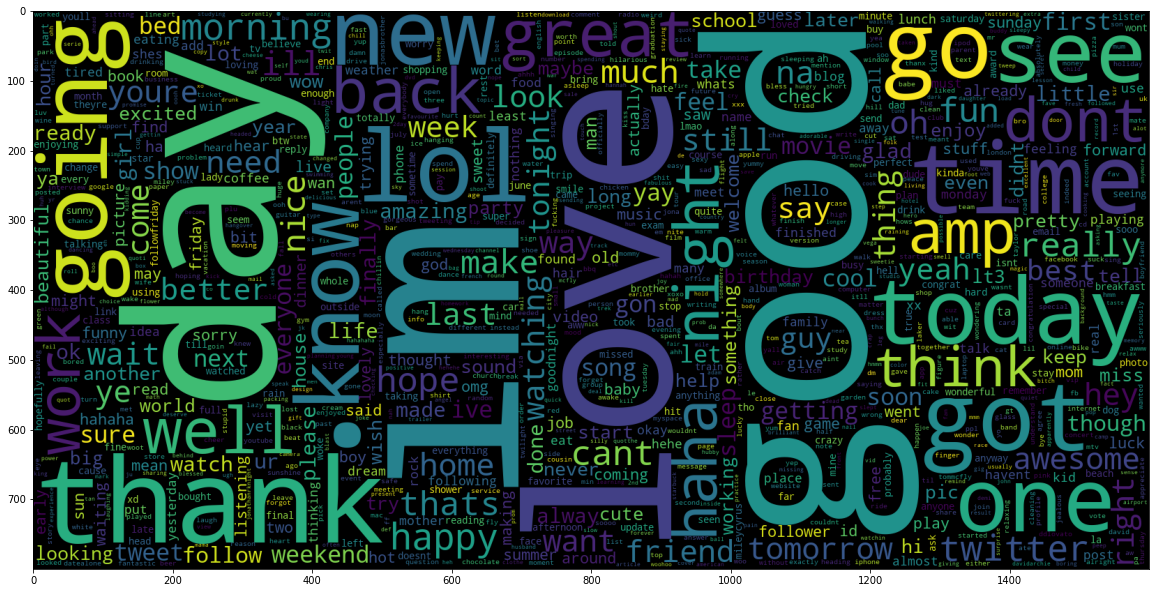

In [ ]:
# Plotting positive tweets

positive_plot = proceseed_tweets[800000:]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(positive_plot))
plt.imshow(wc)

# Splitting the data

After visualizing the data, we now split the dataset into training and testing sets, in order top perform machine learning algorithms

- Training Set: Data upon which the model would be trained on. 95%
- Testing Set: Data upon which the model would be tested on. 5%

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(proceseed_tweets, sentiment, test_size=0.05, random_state=0)

In [ ]:
xtrain[0]

'working double texas roadhouse '

# TF-IDF Vectoriser

Since a machine learning model works with numbers rather than texts, we need a mechanism to score the above pre-processed text in order to feed it into the model

TF-IDF indicates what the importance of the word is in order to understand the document. 

To put that into perspective consider that we have an dataset with essay on house. In this kind of dataset certain words occur frequently compared to other words. Words like home, house, rooms are less frequent compared so some other words, so their frequency is low and carry more information.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
# ngram is range of number of words in a sequence. So "very good" is a 2gram that is considered as a seperate feature from "good"
# training the vectorizer on training data i.e our preprocessed tweets
# tfidf will vectorize our tweets
# learning the vocabulary of the training set.
vectorizer.fit(xtrain)
print('Feature Words: ', len(vectorizer.get_feature_names()))

Feature Words:  500000


# Transforming Dataset

Now, we'll transform the xtrain and the xtest dataset into tf-idf feature matrices. We'll use this dataset to train the model

In [ ]:
xtrain = vectorizer.transform(xtrain)
xtest = vectorizer.transform(xtest)
print('Transformation Completed')


Transformation Completed


In [ ]:
print("Transformed Input:")
print(xtrain[0])

Transformed Input:
  (0, 485419)	0.4682939839153263
  (0, 485301)	0.23150238555158678
  (0, 418661)	0.5092045335912012
  (0, 418616)	0.34707346567858655
  (0, 353080)	0.4863305874230079
  (0, 109200)	0.332927472944861


# Naive Bayes Classifier

The Naive Bayes Classifier uses the **Bayes Theorem** which says that the probability of the **label** (positive or negative) for the given tweet is equal to the probability of we find this tweet given the label times the probability a label occurs, everything divided by the probability of we find this text.

$P(label|word1, word2, ...) = \frac{P(word1, word2, ... | label)*P(label)}{P(word1, word2, ...)}$

It boils down to comparing the probablities of the labels and choosing the one with the highest probability.

In [ ]:
'''
 Training the model
 We are selecting the best hyperparameters via grid search algorithm, which essentially tests out
 a bunch of different hyperparametes and selects one which performs the best. The parameter required here
 in the case of BNB model is alpha, which is a smoothing parameter.
'''
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
         }

# performing grid searhc
bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
bernoulli_nb_grid.fit(xtrain,ytrain)

print('Train Accuracy : %.3f'%bernoulli_nb_grid.best_estimator_.score(xtrain, ytrain))
print('Test Accuracy : %.3f'%bernoulli_nb_grid.best_estimator_.score(xtest, ytest))
print('Best Accuracy Through Grid Search : %.3f'%bernoulli_nb_grid.best_score_)
print('Best Parameters : ',bernoulli_nb_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished


Train Accuracy : 0.821
Test Accuracy : 0.786
Best Accuracy Through Grid Search : 0.786
Best Parameters :  {'alpha': 2.0}


In [ ]:
# Helper function to print testing accuracies, confusion matrix, classification report
def evaluate_model(model):
  # predicting the values!!
  y_pred = model.predict(xtest)

  # classification report for better analysis
  print(classification_report(ytest, y_pred))

  # confusion matrix
  c_matrix = confusion_matrix(ytest, y_pred)

  # plotting the confusion matrix
  categories = ['Negative', 'Positive']
  group = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  group_percent = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group,group_percent)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

  plt.xlabel("Predicted values", fontdict={'size': 12}, labelpad=10)
  plt.ylabel("Actual values", fontdict={'size': 12}, labelpad=10)
  plt.title("Confusion Matrix", fontdict={'size': 20}, pad=20)


              precision    recall  f1-score   support

           0       0.80      0.76      0.78     39989
           1       0.77      0.81      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



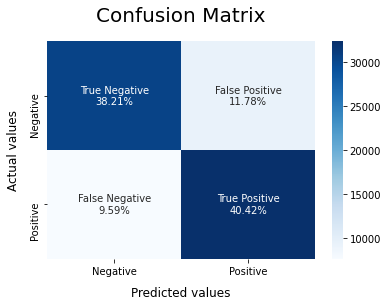

In [ ]:
# since we know the best parameter for training is alpha, let us run that
BernoulliModel = BernoulliNB(alpha=2)
BernoulliModel.fit(xtrain, ytrain)
evaluate_model(BernoulliModel)

In [ ]:
# Trying with MultinomialNB

'''
 Training the model
 We are selecting the best hyperparameters via grid search algorithm, which essentially tests out
 a bunch of different hyperparametes and selects one which performs the best. The parameter required here
 in the case of MNB model is alpha, which is a smoothing parameter.
'''

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
         }

# performing grid search
multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(xtrain,ytrain)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(xtrain, ytrain))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(xtest, ytest))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.5min finished


Train Accuracy : 0.826
Test Accuracy : 0.789
Best Accuracy Through Grid Search : 0.787
Best Parameters :  {'alpha': 2.0}


              precision    recall  f1-score   support

           0       0.78      0.80      0.79     39989
           1       0.80      0.78      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



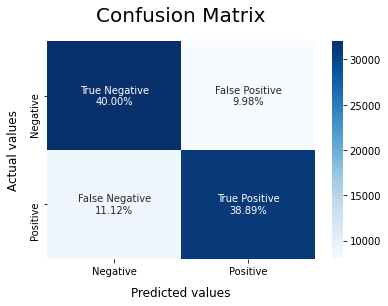

In [ ]:
# since we know the best parameter for training is alpha, let us run that
MultinomialModel = MultinomialNB(alpha=2)
MultinomialModel.fit(xtrain, ytrain)
evaluate_model(MultinomialModel)

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)   
# n_jobs=-1 means using all processors
# max_iter - Maximum number of iterations taken for the solvers to converge.
# Inverse of regularization strength. Smaller values specify stronger regularization.

LRmodel.fit(xtrain, ytrain)


In [ ]:
evaluate_model(LRmodel)

# Saving the Models

In [ ]:
file = open('vectoriser-ngram-(1,2).pickle', 'wb')
pickle.dump(vectorizer, file)
file.close()

file = open('Sentiment-MNB.pickle', 'wb')
pickle.dump(MultinomialModel, file)
file.close()

In [ ]:
def load_models():    
    # Load the vectoriser.
    file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
    NBModel = pickle.load(file)
    file.close()
    
    return vectoriser, NBModel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess_tweet_text(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df1 = pd.DataFrame(data, columns = ['text','sentiment'])
    df1 = df1.replace([0,1], ["Negative","Positive"])
    return df1

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate you",
            "I love you",
            "I don't feel so good",
            "All the best"]
    
    df1 = predict(vectorizer, MultinomialModel, text)
    print(df1.head())

                   text sentiment
0            I hate you  Negative
1            I love you  Positive
2  I don't feel so good  Negative
3          All the best  Positive


# Naive Bayesian Model from Scratch

We've implemented a generic text classifier that puts a tweet into one of two categories - negative or positive sentiment. We'll be using Naive Bayesian Classifier to predict the sentiment of the tweet.

Our model relies on multiplying many probabilities. Those might become increasingly small and our computer might round them down to zero. To combat this, we’re going to use log probability by taking log of each side in our equation: 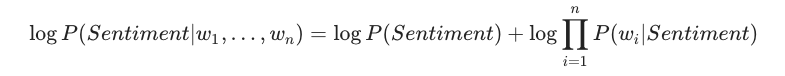

In [ ]:
# multinomial Naive Bayesian Model
class MultinomialNaiveBayes:

    # initialize the tokenizer and classes  
    def __init__(self, classes, tokenizer):
        self.tokenizer = tokenizer
        self.classes = classes 
      
    def group_by_class(self, X, y):   #separate sentiment 0 & 1
      data = dict()     #simply creates a dictionary
      for c in self.classes:
          data[c] = X[np.where(y == c)]
      return data   #in form {0:all_negative_tweets.., 1:all_positive_tweets... }
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()    #returns empty set

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)     
        
        # vectorizing each word using count vectorizer
        for c, data in grouped_data.items():
          # total no of "words" in each class i.e positive or negative (used to find the prior)
          self.n_class_items[c] = len(data)
          # finding prior (based on the dataset)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)  
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    # laplacian smoothing ensures that the probability of a class does not become 0, if a word is not present in the class
    # we just add 1 to the numerator
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1   
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    # to predict the sentiments from text data, we'll use our class priors and vocabulary
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [ ]:
# emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
#           ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
#           ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
#           ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
#           '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
#           '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
#           ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
# Tokenizer is responsible for preprocessing the data
class Tokenizer:

  def clean(self, text):
    no_html = BeautifulSoup(text).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
    return re.sub("(\s+)", " ", clean)

  def tokenize(self, text):
    clean = self.clean(text).lower()
    stopwords_en = stopwords.words("english")
    return [w for w in re.split("\W+", clean) if not w in stopwords_en]

# Data Splitting

In [ ]:
# converting the dataframe object to numpy array for training purposes
print(df)
tw = df['Tweet'].values
snt = df['Sentiment'].values

# splitting into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(tw, snt, test_size=0.05, random_state=42)

         Sentiment                                              Tweet
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


# Fitting the dataset through Multinomial NB

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(sentiment),
    tokenizer=Tokenizer()
).fit(x_train, y_train)

# Prediction

In [ ]:
y_hat = MNB.predict(x_test)

In [ ]:
accuracy_score(y_test, y_hat)

0.7724

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     39999
           1       0.77      0.77      0.77     40001

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



Text(0.5, 1.0, 'Confusion Matrix')

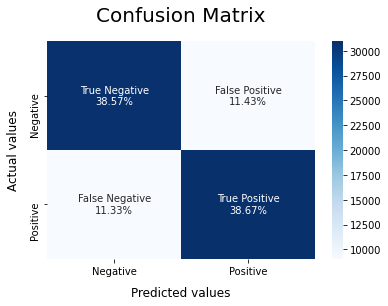

In [ ]:
# cnf_matrix = confusion_matrix(y_test, y_hat)
# print(cnf_matrix)

# confusion matrix
c_matrix = confusion_matrix(y_test, y_hat)

# plotting the confusion matrix
categories = ['Negative', 'Positive']
group = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_percent = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group,group_percent)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted values", fontdict={'size': 12}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 12}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 20}, pad=20)

# Attempting to implement TF-IDF from scratch

In [ ]:
#to be used while implimenting tf-idf from scratch
xtrain_scratch, xtest_scratch, ytrain, ytest = train_test_split(proceseed_tweets[790000:810000], sentiment[790000:810000], test_size=0.05, random_state=0)

In [ ]:
proceseed_tweets[790000],sentiment[790000]  #first 10k tweet with sentiment 0

('virpis last day busy tit ', 0)

In [ ]:
proceseed_tweets[810000],sentiment[810000]  #last 10k tweet with sentiment 1

('gig northampton racehorse tmw night ', 1)

In [ ]:
# # Reducing dataset size 
# df = df.iloc[790000:,]
# df.drop(df.tail(790000).index,inplace = True)
# df.shape

In [ ]:
def IDF(whole_data, unique_words):  #unique_words is vocabulary
    
    N=len(whole_data)  #total tweets
    
    vocab = {j:i for i,j in enumerate(unique_words)}  # ['cat', 'boy'] -> [(0,'cat'), (1,'boy')] #list into tuples
    sparse_matrix= csr_matrix( (N, len(unique_words)), dtype=np.float64)
    
    for tweet_index in range(0,N):
#       print("--",tweet_index,end="--")
        for word in whole_data[tweet_index].split():
                sparse_matrix[tweet_index,vocab[word]] += 1 
        
    idf_dict={}          
    for word in unique_words:  
        word_repeats_in_tweets = sparse_matrix[:,vocab[word]].count_nonzero()
        idf_dict[word]=(math.log((1+N)/(word_repeats_in_tweets+1)))+1
#       print('###completely done###')
    
    return idf_dict   #returns IDF of all unique words

The reason why we are adding ‘1’ to numerator and denominator and also to the whole equation of ‘idf_dict[i]’ is to maintain numerical stability. There might be situations where there are no values, which will generate an error(avoiding division of zeros). So to avoid that error, we are creating numerical stability.

In [ ]:
def fit(whole_data):
    unique_words = set()  #creates set object
    if isinstance(whole_data, (list,)):   #checking that whole_date is of list object 
        for tweet in whole_data:
            unique_words.update(tweet.split())

        unique_words = sorted(list(unique_words))  #sorting the vocab
        #print(unique_words)

        vocab = {j:i for i,j in enumerate(unique_words)}  # ['cat', 'boy'] -> [(0,'cat'), (1,'boy')] #list into tuples
        Idf_values_of_all_unique_words=IDF(whole_data,unique_words)   #('boy',1)
    return vocab, Idf_values_of_all_unique_words

In [ ]:
Vocabulary, idf_of_vocabulary=fit(xtrain_scratch)   #passing the complete tweet training data

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
len(Vocabulary)   #total unique words which form the vocabulary

28522

In [ ]:
 def transform(tweets_dataset,vocabulary,idf_values):
     sparse_matrix= csr_matrix( (len(tweets_dataset), len(vocabulary)), dtype=np.float64)   #empty matrix with shape (total tweets, total unique words) [row x column]
     for row in range(0,len(tweets_dataset)):
       word_repeating_in_tweet = Counter(tweets_dataset[row].split())   #word repeating in a particular tweet
       for word in tweets_dataset[row].split():  #word of a particular tweet
           if word in  list(vocabulary.keys()):
               tf_value = (word_repeating_in_tweet[word] / len(tweets_dataset[row].split()) ); # word repeating in a particular tweet / total words in tweet
               tf_idf_value = tf_value * (idf_values[word])
               sparse_matrix[row,vocabulary[word]] = tf_idf_value   #row, the index attached to a word in vocabulary tuple
     
     #print(sparse_matrix)
     output = normalize(sparse_matrix, norm='l2', axis=1, copy=True, return_norm=False);  #normalised to form a tf-idf matrix
     #print("NORM FORM\n",output)
     return output

In [ ]:
print(xtrain_scratch[0])   #printing the first tweet before transformation

pdurham wasent ablt stop lunch today either busy work lol good 


In [ ]:
xtrain_scratch =transform(xtrain_scratch,Vocabulary,idf_of_vocabulary)
xtest_scratch=transform(xtest_scratch,Vocabulary,idf_of_vocabulary)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
print(xtrain_scratch[0])   #printing the tf-idf of words of first tweet

  (0, 802)	0.435919789847328
  (0, 4058)	0.2878832620826977
  (0, 7808)	0.2846061515296551
  (0, 10110)	0.16277592110270644
  (0, 14787)	0.19682259771689958
  (0, 15078)	0.2620605608056139
  (0, 18741)	0.435919789847328
  (0, 23910)	0.27210445160886376
  (0, 25457)	0.17047394908876393
  (0, 27123)	0.435919789847328
  (0, 27765)	0.17038574907131512


In [ ]:
# Helper function to print testing accuracies, confusion matrix, classification report
def evaluate_model(model):
  # predicting the values!!
  y_pred = model.predict(xtest_scratch)

  # classification report for better analysis
  print(classification_report(ytest, y_pred))

  # confusion matrix
  c_matrix = confusion_matrix(ytest, y_pred)

  # plotting the confusion matrix
  categories = ['Negative', 'Positive']
  group = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  group_percent = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group,group_percent)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

  plt.xlabel("Predicted values", fontdict={'size': 12}, labelpad=10)
  plt.ylabel("Actual values", fontdict={'size': 12}, labelpad=10)
  plt.title("Confusion Matrix", fontdict={'size': 20}, pad=20)

In [ ]:
# Trying with MultinomialNB

'''
 Training the model
 We are selecting the best hyperparameters via grid search algorithm, which essentially tests out
 a bunch of different hyperparametes and selects one which performs the best. The parameter required here
 in the case of MNB model is alpha, which is a smoothing parameter.
'''
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
         }

# performing grid search
multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(xtrain_scratch,ytrain)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(xtrain_scratch, ytrain))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(xtest_scratch, ytest))  #change x_test to xtest tfidf inbuilt

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s


Train Accuracy : 0.900
Best Accuracy Through Grid Search : 0.759
Best Parameters :  {'alpha': 1.5}
Test Accuracy : 0.745


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.1s finished


              precision    recall  f1-score   support

           0       0.71      0.81      0.76       494
           1       0.78      0.69      0.73       506

    accuracy                           0.74      1000
   macro avg       0.75      0.75      0.74      1000
weighted avg       0.75      0.74      0.74      1000



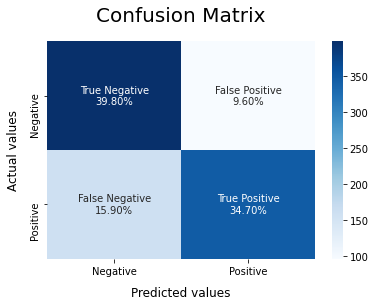

In [ ]:
# since we know the best parameter for training is alpha, let us run that
MultinomialModel = MultinomialNB(alpha=1.5)
MultinomialModel.fit(xtrain_scratch, ytrain)
evaluate_model(MultinomialModel)